In [1]:
import gc
import os
from pathlib import Path
import pickle
import time

import lightfm
import catboost
import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy import sparse

In [2]:
data_dir = '/dataset/h-and-m-finish-preprocess/h-and-m-finish-preprocess'
output_dir = '/model'
transactions = pd.read_pickle(f"{data_dir}/transactions_train.pkl") # 读取 transactions_train
users = pd.read_pickle(f"{data_dir}/users.pkl") # 读取 users
items = pd.read_pickle(f"{data_dir}/items.pkl") # 读取 items

In [3]:
class CFG:
    model_type = 'CatBoost' # 使用模型 /CatBoost
    # candidates
    popular_num_items = 60 # 最受欢迎的前n个items
    popular_weeks = 1 # n个week内，最受欢迎的items
    train_weeks = 6 # 训练使用的week数
    item2item_num_items_for_same_product_code = 12 # 每个user最大数量的items

    # features
    user_transaction_feature_weeks = 50 # user 交易表跟踪时间
    item_transaction_feature_weeks = 16 # item 交易表跟踪时间
    item_age_feature_weeks = 40 # 每个item的购买年龄 - n个week内
    user_volume_feature_weeks = 50 # 每个user购买量 - n个week内
    item_volume_feature_weeks = 20 # 每个item的被购买量 - n个week内
    user_item_volume_feature_weeks = 16 # user-item购买量 - n个week内


## 生成candidates

In [4]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users
        候选项生成的目标用户
    week
        距离目前n周
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users)) # target_users中没有user的重复

    def create_candidates_repurchase(
            strategy: str,  # 策略名称
            transactions: pd.DataFrame, # 交易数据
            target_users: np.ndarray, # 指定user
            week_start: int, # 开始的week
            max_items_per_user: int = 12 # 每个user最大数量的items
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True) # 筛选指定user和week的交易样本

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day') # user-item对的最近一天
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week') # user-item对的最近一周
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume') # user-item对的样本总数

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank() # 每个user的day排名
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank() # 每个user的week排名
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False) # 每个user的样本总数降序排名

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item']) # 合并上述三种groupby user的结果

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank'] # 先按day，再按volume做rank
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min') # 相同rank_meta时都取最小值
        
        # 如果用于 item2item，请删除所有项目，因为使用所有项目会造成不必要的负担。
        # 按日小、量大的词法顺序排序，只保留最前面的项目。
        # 如果你想保留所有项目，在max_items_per_user中指定一个足够大的数字。
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True) # 每个user保留最大数量的items

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy 
        return candidates.drop_duplicates(ignore_index=True)


    def  create_candidates_popular(
            transactions: pd.DataFrame, # 交易数据
            target_users: np.ndarray, # 指定user
            week_start: int, # 开始的week
            num_weeks: int, # 持续week数量
            num_items: int, # 最受欢迎的前n个items
        ) -> pd.DataFrame:
        '''
        最受欢迎items排名策略
        '''
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True) # 指定week时间段的user-item对
        popular_items = tr['item'].value_counts().index.values[:num_items] # 交易数据中最受欢迎的前num_items个items # value_counts会自动降序排序
        popular_items = pd.DataFrame({
            'item': popular_items, # 最受欢迎item列表
            'rank': range(num_items), # item rank list
            'crossjoinkey': 1, 
        })

        candidates = pd.DataFrame({
            'user': target_users, # 指定user列表
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1) # 指定user表 和 最受欢迎item表 笛卡尔积
        candidates = candidates.rename(columns={'rank': f'pop_rank'}) 

        candidates['strategy'] = 'pop' # 最受欢迎items策略
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_category_popular(
        transactions: pd.DataFrame, # 交易数据表
        items: pd.DataFrame, # item表
        base_candidates: pd.DataFrame, # 基候选项表
        week_start: int, # 开始的week
        num_weeks: int, # 持续week数量
        num_items_per_category: int, # 属性值数量最多的n个属性值
        category: str, # 属性名称
    ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates() # 指定week时间段的user-item对
        tr = tr.groupby('item').size().reset_index(name='volume') # 每个item的交易样本总数
        tr = tr.merge(items[['item', category]], on='item') # 加入item的category特征
        tr['cat_volume_rank'] = tr.groupby(category)['volume'].rank(ascending=False, method='min') # category每个属性值的数量排序
        tr = tr.query("cat_volume_rank <= @num_items_per_category").reset_index(drop=True) # 保留属性值数量前n的样本
        tr = tr[['item', category, 'cat_volume_rank']].reset_index(drop=True)

        candidates = base_candidates[['user', 'item']].merge(items[['item', category]], on='item') # 在基候选项表中category特征
        candidates = candidates.groupby(['user', category]).size().reset_index(name='cat_volume') # user-category对的样本数量
        candidates = candidates.merge(tr, on=category).drop(category, axis=1)
        candidates['strategy'] = 'cat_pop' # 各特征最受欢迎items策略
        return candidates


    # 生成候选项
    # repurchase
    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    # popular
    candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    # item2item2
    candidates_item2item2 = create_candidates_repurchase('item2item2', transactions, target_users, week, CFG.item2item_num_items_for_same_product_code) 
    # category popular
    candidates_dept = create_candidates_category_popular(transactions, items, candidates_item2item2, week, 1, 6, 'department_no_idx')

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        从 candidates_target 中 drop 那些在 candidates_reference 出现过的 user-item 对
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True) # 获取 candidates_reference 的 user-item 对
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left') # 标注出在 candidates_reference 出现过的 user-item 对
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1) # drop并返回
    candidates_dept = drop_common_user_item(candidates_dept, candidates_repurchase) # 从 candidates_target 中 drop 那些在 candidates_reference 出现过的 user-item 对

    # 合并所有 candidates
    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_dept,
    ]
    candidates = pd.concat(candidates)
    
    # 打印有多少 candidates 样本
    print(f"volume: {len(candidates)}") 
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}") # 所有样本中 user-item 对的重复率

    # 查看一下每种策略的样本数 和 占比
    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)  
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    # 删除 meta 列名
    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1) 


In [5]:
# valid: week=0
# train: week=1+CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks): # 0,1,2,3,4,5,6
    target_users = transactions.query("week == @week")['user'].unique() # 某个week有交易的user
    candidates.append(create_candidates(transactions, target_users, week+1)) # 生成candidates, 注意是上一周（week+1）

create candidates (week: 1)
volume: 8105042
duplicates: 1.0637283505169521
     strategy   volume     ratio
0         pop  4139040  0.510675
1     cat_pop  3185904  0.393077
2  repurchase   780098  0.096248
create candidates (week: 2)
volume: 8429811
duplicates: 1.0683223288174686
     strategy   volume     ratio
0         pop  4321140  0.512602
1     cat_pop  3288085  0.390054
2  repurchase   820586  0.097343
create candidates (week: 3)
volume: 8830840
duplicates: 1.077709892716436
     strategy   volume     ratio
0         pop  4549320  0.515163
1     cat_pop  3422234  0.387532
2  repurchase   859286  0.097305
create candidates (week: 4)
volume: 9406133
duplicates: 1.08244149593463
     strategy   volume     ratio
0         pop  4815180  0.511919
1     cat_pop  3675499  0.390756
2  repurchase   915454  0.097325
create candidates (week: 5)
volume: 8447395
duplicates: 1.0956858559887062
     strategy   volume     ratio
0         pop  4322100  0.511649
1     cat_pop  3297816  0.390394
2

## 生成candidates对应的labels

In [6]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    print(f"merge labels (week: {week})") 
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True) # 交易表中某week的 user-item对
    original_positives = len(labels) # 交易表中某week的 user-item对 数量, 即正样本数量
    # 候选项中的user-item对在交易表中出现，则y为1，未出现则为0
    labels['y'] = 1
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)
    
    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum() # TP
    recall = remaining_positives_total / original_positives # Recall = TP/正样本数量
    print(f"Recall: {recall}")

    # 查看一下每种策略的Recall和Accuracy
    volumes = candidates.groupby('strategy').size().reset_index(name='volume') # 每种策略的样本数
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index() # 每种策略的TP
    remaining_positives = remaining_positives.merge(volumes, on='strategy') # 合并: 每种策略的 TP和样本数
    remaining_positives['recall'] = remaining_positives['y'] / original_positives # Recall = TP/正样本数
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume'] # hit_ratio/accuracy
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives) # 打印每个策略的Recall和Accuracy

    return labels # 返回 候选项中的每个user-item对 + candidates特征 + y

In [7]:
# 每周 candidate 加上 labels
for idx in range(len(candidates)): # 0,1,2,3,4,5,6
    candidates[idx] = merge_labels(candidates[idx], idx) # 候选项中的每个user-item对 + candidates特征 + y

merge labels (week: 0)
Recall: 0.13820369815840694
     strategy        y   volume    recall  hit_ratio
0         pop  16630.0  4139040  0.077809   0.004018
1     cat_pop  10353.0  3185904  0.048440   0.003250
2  repurchase   6468.0   780098  0.030263   0.008291
merge labels (week: 1)
Recall: 0.12228072484752753
     strategy        y   volume    recall  hit_ratio
0         pop  14822.0  4321140  0.065034   0.003430
1     cat_pop   9783.0  3288085  0.042925   0.002975
2  repurchase   6884.0   820586  0.030205   0.008389
merge labels (week: 2)
Recall: 0.12777119719078942
     strategy        y   volume    recall  hit_ratio
0         pop  16898.0  4549320  0.070978   0.003714
1     cat_pop  11074.0  3422234  0.046515   0.003236
2  repurchase   6776.0   859286  0.028462   0.007886
merge labels (week: 3)
Recall: 0.12577006881632782
     strategy        y   volume    recall  hit_ratio
0         pop  18262.0  4815180  0.071567   0.003793
1     cat_pop  12088.0  3675499  0.047372   0.003289
2

## candidates数据 再处理

In [8]:
# 1. 加入week列
for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

# 2. 最近一周，作为验证集
candidates_valid_all = candidates[0].copy()

# 3. 删除单一标签用户
def drop_trivial_users(labels):
    """
    在LightGBM xendgc和lambdarank中，只有正面或负面样本的单一标签用户需要删除，因为它们对训练没有意义，而且度量计算也是错误的。
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True) # 保留同时用正面和负面样本的用户
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}") # 前后样本数量变化
    return df
    
for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])

drop trivial queries: 8105042 -> 2615315
drop trivial queries: 8429811 -> 2556995
drop trivial queries: 8830840 -> 2779324
drop trivial queries: 9406133 -> 2949707
drop trivial queries: 8447395 -> 2416618
drop trivial queries: 8432834 -> 2266012
drop trivial queries: 8741982 -> 2210474


In [9]:
# candidates columns = ['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'strategy', 'pop_rank', 'cat_volume', 'cat_volume_rank', 'y', 'week']

## attach features

In [10]:
def calc_embeddings(model_type: str, week: int, dim: int):
    # 载入lfm model
    with open(f"{data_dir}/lfm/lfm_{model_type}_week{week}_dim{dim}_model.pkl", 'rb') as f:
        model = pickle.load(f)
    # 获取 user 信息
    biases, embeddings = model.get_user_representations(None)
    n_user = len(biases) # n个users
    a = np.hstack([embeddings, biases.reshape(n_user, 1)]) # 合并 embeddings 和 biases
    user_embeddings = pd.DataFrame(a, columns=[f"user_rep_{i}" for i in range(dim + 1)]) # 每一维都是一个特征
    user_embeddings = pd.concat([pd.DataFrame({'user': range(n_user)}), user_embeddings], axis=1) # 获得 user_embeddings

    return user_embeddings

In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    print(f"attach features (week: {week})")
    n_original = len(candidates) # 候选项样本数量
    df = candidates.copy() # 候选项df

    # user静态特征, 加入年龄
    df = df.merge(users[['user', 'age']], on='user')

    # item静态特征，所有idx结尾特征
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user动态特征 (transactions)
    week_end = week + CFG.user_transaction_feature_weeks
    # 交易表中，每个用户在某个时间段的[price 和 sales_channel_id]的[平均值,标准差]
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()] # 加入列名后缀 ，如 user_price_mean, user_price_std, user_sales_channel_id_mean, user_sales_channel_id_std
    df = df.merge(tmp, on='user', how='left') # merge新列

    # item动态特征 (transactions)
    week_end = week + CFG.item_transaction_feature_weeks
    # 交易表中，每个item在某个时间段的[price 和 sales_channel_id]的[平均值,标准差]
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()] # 加入列名后缀
    df = df.merge(tmp, on='item', how='left') # merge新列

    # item动态特征  (user features)
    week_end = week + CFG.item_age_feature_weeks
    # 交易表某段week，加入年龄列
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std']) # 每个item的购买年龄的[mean和std]
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()] # 加入列名后缀
    df = df.merge(tmp, on='item', how='left') # merge新列

    # item新鲜度特征
    tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min') # 指定week及之前，每个item的最近一次被购买的day
    tmp['item_day_min'] -= transactions.query("@week == week")['day'].min() # item有多少天没有被购买了。
    df = df.merge(tmp, on='item', how='left') # merge新列 

    # 每个item被购买量
    week_end = week + CFG.item_volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume') # 时间范围内每个item的被购买量
    df = df.merge(tmp, on='item', how='left')

    # user新鲜度特征
    tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min') # 每个user最近一次购买的day
    tmp['user_day_min'] -= transactions.query("@week == week")['day'].min() # 该user有多少天没有购买了
    df = df.merge(tmp, on='user', how='left')

    # 每个user购买量
    week_end = week + CFG.user_volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume') # 每个user购买量
    df = df.merge(tmp, on='user', how='left') 

    # user-item对新鲜度特征
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min') # 每个user最近一次购买某个item的day
    tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min() # 该user有多少天没有购买该item了
    df = df.merge(tmp, on=['item', 'user'], how='left') 

    # user-item购买量
    week_end = week + CFG.user_item_volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    # lfm features
    seen_users = transactions.query("week >= @pretrain_week")['user'].unique() # lfm_week 之前的 user (或者称为已知用户)
    user_reps = calc_embeddings('i_i', pretrain_week, 16) # 获取user_embeddings
    user_reps = user_reps.query("user in @seen_users") # user 属于已知用户
    df = df.merge(user_reps, on='user', how='left') 

    assert len(df) == n_original
    return df

# 生成验证特征数据
dataset_oof = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# 生成训练特征数据
datasets_train_valid = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)
attach features (week: 1)
attach features (week: 2)
attach features (week: 3)
attach features (week: 4)
attach features (week: 5)
attach features (week: 6)
attach features (week: 7)


In [12]:
datasets_train_valid[3].shape

(2949707, 55)

## 划分Train/Valid

In [ ]:
# 按week、user排序 
for idx in range(len(datasets_train_valid)): # 循环每周 candidates df
    datasets_train_valid[idx]['query_group'] = datasets_train_valid[idx]['week'].astype(str) + '_' + datasets_train_valid[idx]['user'].astype(str) # 新列 query_group = "week_user"
    datasets_train_valid[idx] = datasets_train_valid[idx].sort_values(by='query_group').reset_index(drop=True) # 按照query_group升序

# 获取 train 和 valid, train需要concat合并
def concat_train(datasets_train_valid, begin, num):
    train = pd.concat([datasets_train_valid[idx] for idx in range(begin, begin+num)])
    return train

train = concat_train(datasets_train_valid, 1, CFG.train_weeks) # train data
valid = datasets_train_valid[0] # valid data

# 特征列
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']] # 
print(f"feature_columns:\n{feature_columns}") # 打印特征列列名

# 标签编码特征 #catboost需要用
cat_feature_values = [c for c in feature_columns if c.endswith('idx')] # 标签编码特征的列名
cat_features = [feature_columns.index(c) for c in cat_feature_values] # 该列名在列表中的位置
print(f"\ncat_feature_values:\n{cat_feature_values}")
print(f"\ncat_features:\n{cat_features}")

feature_columns:
['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cat_volume', 'cat_volume_rank', 'age', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'user_rep_0', 'user_rep_1', 'user_rep_2', 'user_rep_3', 'user_rep_4', 'user_rep_5', 'user_rep_6', 'user_rep_7', 'user_rep_8', 'user_rep_9', 'user_rep_10', 'user_rep_11', 'user_rep_12', 'user_rep_13', 'user_rep_14', 'user_rep_15', 'user_rep_16']

cat_feature_values:
['pro

In [ ]:
train.head().iloc[:3]

,user,item,repurchase_week_rank,repurchase_volume_rank,strategy,pop_rank,cat_volume,cat_volume_rank,y,week,...,user_rep_8,user_rep_9,user_rep_10,user_rep_11,user_rep_12,user_rep_13,user_rep_14,user_rep_15,user_rep_16,query_group
0,100000,63386,NaN,NaN,cat_pop,NaN,1.0,3.0,0.0,1,...,0.006043,0.09423,-0.012571,-0.046699,-0.169949,0.173077,-0.032182,-0.13273,-0.117689,1_100000
1,100000,53896,NaN,NaN,pop,55.0,NaN,NaN,0.0,1,...,0.006043,0.09423,-0.012571,-0.046699,-0.169949,0.173077,-0.032182,-0.13273,-0.117689,1_100000
2,100000,22648,NaN,NaN,cat_pop,NaN,1.0,2.0,0.0,1,...,0.006043,0.09423,-0.012571,-0.046699,-0.169949,0.173077,-0.032182,-0.13273,-0.117689,1_100000


In [16]:
cat_features

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

## Model Training

In [26]:
def get_query_group(df):
    '''
    user 组
    '''
    users = df['user'].values # users value
    comp_seq_index, = np.concatenate(([True], users[1:]!=users[:-1], [True])).nonzero() # user_id分界处为True，首尾各加一个True。然后nonzero返回所有True的索引号
    group = list(np.ediff1d(comp_seq_index)) # 滚动作差，得到每个group的数量，即需要返回的值
    return group

In [33]:
# 打开文件，如果文件不存在则创建它
with open(f'/code/feature_columns.txt', 'w') as file:
    # 写入文本
    file.write(str(feature_columns))
with open(f'/code/cat_features.txt', 'w') as file:
    # 写入文本
    file.write(str(cat_features))

In [35]:
# train.to_pickle(f'/code/train_after_process.pkl') # 保存验证集
# valid.to_pickle(f'/code/valid_after_process.pkl') # 保存验证集

In [ ]:
# # Save
# train_dataset = catboost.Pool(data=train.iloc[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
# valid_dataset = catboost.Pool(data=valid.iloc[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

0:	test: 0.1452107	best: 0.1452107 (0)	total: 691ms	remaining: 1h 55m 7s
1:	test: 0.1600601	best: 0.1600601 (1)	total: 1.44s	remaining: 2h 13s
2:	test: 0.1599088	best: 0.1600601 (1)	total: 2.15s	remaining: 1h 59m 20s
3:	test: 0.1639011	best: 0.1639011 (3)	total: 2.83s	remaining: 1h 57m 41s
4:	test: 0.1806964	best: 0.1806964 (4)	total: 3.54s	remaining: 1h 58m 8s
5:	test: 0.1804629	best: 0.1806964 (4)	total: 4.3s	remaining: 1h 59m 19s
6:	test: 0.1842677	best: 0.1842677 (6)	total: 5.12s	remaining: 2h 1m 47s
7:	test: 0.1851662	best: 0.1851662 (7)	total: 5.96s	remaining: 2h 4m 1s
8:	test: 0.1852291	best: 0.1852291 (8)	total: 6.66s	remaining: 2h 3m 15s
9:	test: 0.1881761	best: 0.1881761 (9)	total: 7.43s	remaining: 2h 3m 43s
10:	test: 0.1893696	best: 0.1893696 (10)	total: 8.13s	remaining: 2h 3m 4s
11:	test: 0.2033257	best: 0.2033257 (11)	total: 8.84s	remaining: 2h 2m 40s
12:	test: 0.2041968	best: 0.2041968 (12)	total: 9.55s	remaining: 2h 2m 14s
13:	test: 0.2041006	best: 0.2041968 (12)	total: 

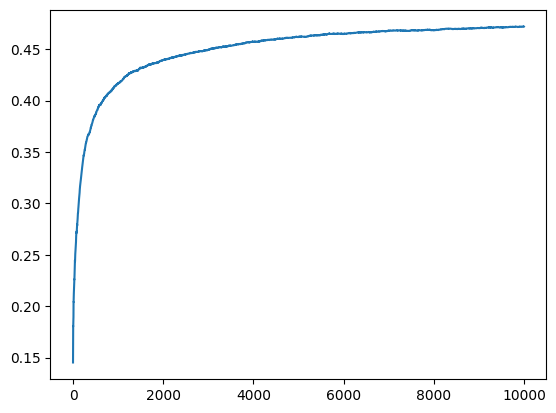

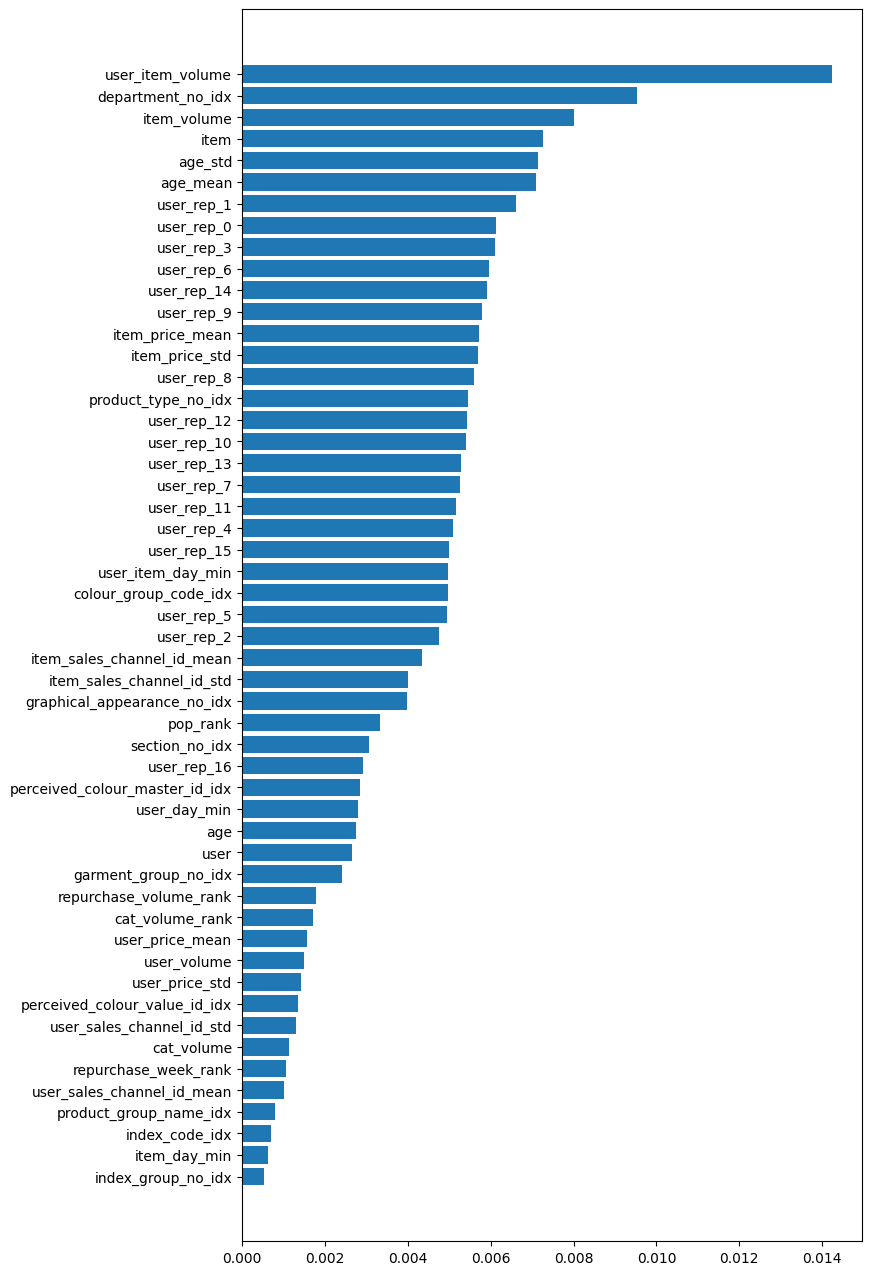

In [37]:
if CFG.model_type == 'LightGBM':
    # user group，得到每个group的数量
    group_train = get_query_group(train) 
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset) # 验证集需要 reference 训练集

    params = {
        'objective': 'xendcg', # 排序
        'boosting_type': 'gbdt', # 提升树
        'learning_rate': 1e-6, # 学习率
        'num_leaves': 255, # leaves数
        'min_data_in_leaf': 100, # 每个叶节点的最少样本数量。
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(
                        params, # 参数
                        train_dataset, # 训练数据
                        valid_sets=[train_dataset, valid_dataset], # 验证数据
                        num_boost_round=1000,  # 迭代数
                        callbacks=[lgb.early_stopping(20)] # 早停法20轮
                    )

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16)) # 特征重要度

elif CFG.model_type == 'CatBoost':
    
    
    train_dataset = catboost.Pool(data=train.iloc[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid.iloc[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 10000,
#         'task_type':'GPU'
    }
    model = catboost.CatBoost(params) # 创建模型
    model.fit(train_dataset, eval_set=valid_dataset) # 训练模型

    plt.plot(model.get_evals_result()['validation']['PFound']) # 打印验证结果

    # 特征重要度
    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, valid, train_dataset, valid_dataset
gc.collect()

# 保存模型
with open(f'{output_dir}/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [38]:
# 保存模型
with open(f'/code/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

## Validation

In [39]:
pred = dataset_oof[['user', 'item']].reset_index(drop=True) # 验证集的 user-item对
pred['pred'] = model.predict(dataset_oof[feature_columns]) # 验证集的 模型输出值

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index() # user-item对 的模型输出值 的最大值
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index() # 获取每个user 预测概率最大的前12个item

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'}) # 获取groud truth
merged = gt.merge(pred, on='user', how='left') 
merged['item'] = merged['item'].fillna('').apply(list) # FN 填充为 ""

merged.to_pickle(f'{output_dir}/merged_100.pkl') # 保存gt和预测结果
dataset_oof.to_pickle(f'{output_dir}/valid_all_100.pkl') # 保存验证集

In [ ]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(actual, predicted, k=12):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted) > k:
        predicted = predicted[:k] # 截断12个预测值

    score = 0.0 
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]: # p not in predicted[:i] 意味着 pred不能重复出现
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0 # gt为空，返回0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=12):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


print('mAP@12:', mapk(merged['gt'], merged['item'])) # 计算验证集score

## submission

In [ ]:
# 使用全量数据训练

datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]
# 按week、user排序
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str) # 新列 query_group = week_user
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True) # 按照 query_group 排序

train = concat_train(datasets, 0, CFG.train_weeks) # 从第0周开始全量数据

if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train) # user 组
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train) # 训练集

    best_iteration = model.best_iteration # 训练模型的最佳迭代数
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration) # 训练模型
    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16)) # 模型特征重要度


elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()# 训练模型的最佳迭代数
    params['use_best_model'] = False # 跑慢迭代数
    model = catboost.CatBoost(params) # 创建模型/导入参数
    model.fit(train_dataset) # 训练模型
    # 模型特征重要度
    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, train_dataset
gc.collect()
with open(f'{output_dir}/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f) # 保存模型


del datasets, dataset_oof, candidates, candidates_valid_all
gc.collect()

In [ ]:
all_users = users['user'].values 
all_users # 全量用户
preds = []

# 分chunk读取, to avoid OOM
n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0) # 生成候选项
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks) # 加入附加特征

    candidates['pred'] = model.predict(candidates[feature_columns]) # 模型预测
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index() # user-item对 的预测最大值
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index() # 获取每个user 预测概率最大的前12个item
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True) # 合并所有预测值
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

In [ ]:
# user原值map 和 item原值map
mp_user = pd.read_pickle(f"{data_dir}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"{data_dir}/mp_article_id.pkl") # 
a_user = mp_user['val'].values 
a_item = mp_item['val'].values

# 调整user和item格式
pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))
pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x))) 

# 输出submission.csv
submission = pred[['customer_id', 'prediction']] 
submission.to_csv('submission.csv', index=False) 